Dad Joke Filter
Goal: Make a filter for my dad that can predict if a joke of his is funny
This Notebook: Filter jokes based off of his type, remove mispellings, and create a binary classifcation datset containing funny and not funny jokes

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import regex as re
import pickle
import emoji

import warnings
warnings.filterwarnings('ignore')

# custom functions
from utils import *
from jupyterthemes import jtplot
jtplot.style()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Read-in and explore the dataset

In [2]:
# extract the data
df = pd.read_csv('https://query.data.world/s/htrdsouy327xqa4w457qx6k6sjtj6r')

In [3]:
# examine the data
df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,self.jokes,NaN,My corona is covered with foreskin so it is no...,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,self.jokes,NaN,It's called Google Sheets.,Did you know Google now has a platform for rec...,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,self.jokes,NaN,The vacuum doesn't snore after sex.\n\n&amp;#x...,What is the difference between my wife and my ...,15
3,post,ftbnxh,2qh72,jokes,False,1585785428,https://old.reddit.com/r/Jokes/comments/ftbnxh...,self.jokes,NaN,[removed],My last joke for now.,9
4,post,ftbjpg,2qh72,jokes,False,1585785009,https://old.reddit.com/r/Jokes/comments/ftbjpg...,self.jokes,NaN,[removed],The Nintendo 64 turns 18 this week...,134


In [4]:
df.shape

(1000000, 12)

In [5]:
pd.options.display.max_colwidth = None
df[['title', 'selftext', 'score']].head(10)

,title,selftext,score
0,I am soooo glad I'm not circumcised!,My corona is covered with foreskin so it is not exposed to viruses.,2
1,Did you know Google now has a platform for recording your bowel movements?,It's called Google Sheets.,9
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife.",15
3,My last joke for now.,[removed],9
4,The Nintendo 64 turns 18 this week...,[removed],134
5,Sex with teacher.,[removed],1
6,Another long one.,[removed],8
7,What did the French man say to the attractive teletubby?,Oo..lala...,2
8,A Priest takes a walk down to the docks one day,[removed],88
9,A long joke.,[removed],4


In [6]:
df['score'].describe()

count    1000000.000000
mean         139.691119
std         1674.046005
min            0.000000
25%            0.000000
50%            1.000000
75%            7.000000
max       142733.000000
Name: score, dtype: float64

Saving figure scores distribution


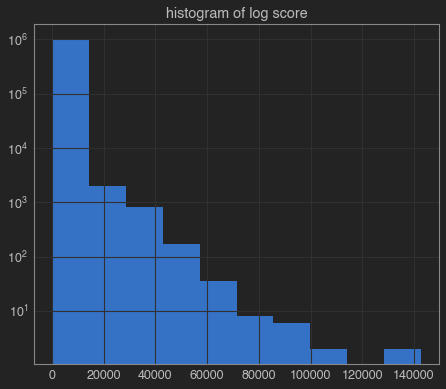

In [7]:
plt.hist(df['score'], log=True)
plt.title('histogram of log score')
save_fig('scores distribution')

In [8]:
# define some parameters 
CLASS_SIZE = 100000
TRAIN_SIZE = 0.95
MIN_UPVOTES = 50
MAX_UPVOTES = df['score'].max()
TITLE_MAX_LEN = 200
SELFTEXT_MAX_LEN = 200

In [9]:
# boolean masks

# where selftext isnull (no punchline)
is_null = df['selftext'].isnull()

# where title or post were removed by reddit user/mod
removed = (df['selftext'].str.lower() == '[removed]') | (df['title'].str.lower() == '[removed]')

# where tile or post were deleted by the original poster
deleted = (df['selftext'].str.lower() == '[deleted]') | (df['title'].str.lower() == '[deleted]')

# reposts
duplicated = df.duplicated(subset=['title', 'selftext'], keep='first')

# where upvotes is 0 (reddit automatically provides user 1 upvote)
neg_class = df['score'] == 0

In [10]:
# get entries that aren't removed or deleted
df_cleaned = df[~removed][~deleted][~duplicated].copy()
df_cleaned.shape

(565688, 12)

In [11]:
# what are nans?
df_cleaned[df_cleaned['score'] > 2000][is_null][['title', 'selftext', 'score']].head(10) 

,title,selftext,score
308797,What happens when you cross a joke with a rhetorical question?,NaN,3938
625315,The funniest /r/jokes has ever been,NaN,67950
914649,Shout out to people who don't know the opposite of in,NaN,4580
915783,5 out of 6 scientists say Russian Roulette is safe.,NaN,10085
919422,"Accordion to a recent survey, replacing words with the names of musical instruments in a sentence often goes undetected.",NaN,12580
927114,"Never make fun of a fat girl with a lisp, she's probably thick and tired of it.",NaN,7848
931755,"6:30 is the best time on a clock, hands down.",NaN,2173
933895,"Bruce Jenner winning woman of the year just proves that men are better than women at everything, including being a woman",NaN,11999
935376,"I often say to myself, ""I can't believe that cloning machine worked.""",NaN,6524
937567,How Long is a Chinese name.,NaN,2404


In [12]:
df_cleaned = df_cleaned[~is_null]

In [13]:
PATTERN = r"(?<![a-z])(e|E)(d|D)(i|I)(t|T)\W.+"

# remove user edits added after user posted content
df_cleaned['title'] = df_cleaned['title'].apply(lambda x:re.sub(PATTERN, " ", x))
df_cleaned['selftext'] = df_cleaned['selftext'].apply(lambda x:re.sub(PATTERN, " ", x))

In [14]:
# Filter entries that are short, but meet other necessary criteria
# remove unnecessary whitespace 
df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(x).split()))

# get length
df_cleaned['selftext_len'] = df_cleaned['selftext'].str.len()
df_cleaned['title_len'] = df_cleaned['selftext'].str.len()

# boolean masks to filter for length
title_window = (df_cleaned['title_len'] > 0) & (df_cleaned['title_len'] < TITLE_MAX_LEN)
selftext_window = (df_cleaned['selftext_len'] > 0) & (df_cleaned['selftext_len'] < SELFTEXT_MAX_LEN)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print(f"{len(df_cleaned[~neg_class])} samples match")

360692 samples match


In [15]:
# meta jokes
# boolean mask that identifies strings with reddit posts
PATTERN = r"(\s\/?[ur]\/\D)|(\sclick\s)|(sub)?(reddit)|\S(vote)s?|(\sop\s)|https?\S+|([a-z]?(re)?post(?=(ed)|[^a-z]|$))|_"
is_meta = df_cleaned['title'].str.lower().str.contains(PATTERN, regex=True) | df_cleaned['selftext'].str.lower().str.contains(PATTERN, regex=True)
df_cleaned[is_meta].sample(10)[['title', 'selftext', 'score']]

,title,selftext,score
132046,How do you know when a Redditor has left a hotel?,Username checks out,928
774810,Why is the homeless /r/anime mod still homeless?,"Every time someone tries to give him Shelter, he rejects it.",2
840386,Im looking for something funny to say on Reddit,On reddit,0
210359,What's a Reddit user's favorite place to get credit scores?,Credit Karma,1
191770,Redditers have forgotten how great Game of Thrones seasons 1-7 were,"But to be fair, so have Benioff and Weiss",3
186068,"Redditors who were children of anti-vaxxers, how difficult was it growing up?","My bad, that's probably my dumbest ask-reddit question yet.",5
565727,I got a girlfriend today!,I wish I could post this on any other thread.,1639
522906,"""Have you seen the new reddit app update?""","""Yeah. They really blueit this time.""",2
342743,Q Walks Into A Bar,"\-Q walks into a bar. \-Fascist Reddit Bartender, says: Get out.",0
74979,What do you call lizard picture posted on Reddit?,A karma chameleon,7


In [16]:
df_cleaned = df_cleaned[~is_meta]

In [17]:
# offensive jokes
# boolean mask that identifies strings with offensive content
PATTERN = r"(?<![a-z])(nsfw).?|(\swhore\w?)|(\shookers?\s)|(\sorgasm\w?)|(\ssex\s)|(\sdicks?\s)|(\sboobs?\s)|(\spenis\s)|(\svaginas?\s)|(\snipples?\s)|(\srape\w?)|(\sanal\s)|(\sniggers?\s)|(\stits?\s)|(\sblack people\s)|(\sblack m(a|e)n\s)|(cocks?\s)|(\spussy\s)|(\scunt\s)|(\sgay\s)"
is_offensive = df_cleaned['title'].str.lower().str.contains(PATTERN, regex=True) | df_cleaned['selftext'].str.lower().str.contains(PATTERN, regex=True)

# uncomment below to check this NSFW
#df_cleaned[is_offensive & is_short].sample(30)[['title', 'selftext', 'score']]

In [18]:
df_cleaned = df_cleaned[~is_offensive]

In [19]:
# removing html character references and tags
PATTERN_empty_string = r"&.+;|\(.+\)|\[.+\]"

# removing punctuation, unnecessary characters
PATTERN_single_space = r"[\\\-\"*.?!,“”:£$#/~;\^=]"

df_cleaned[df_cleaned['selftext'].str.contains(PATTERN_empty_string, regex=True)][['title', 'selftext']].sample(10)

,title,selftext
712422,I like my women like I like my whiskey....,"Over 18, single &amp; either Irish or Scottish"
44965,When someone asks me what kind of berry you want for your breakfast cereals,I say I prefer Ale for breakfast Ale Berry &amp;#x200B; \--- Just invented it after a photo of Halle Berry on the landing page x)
856299,Why did God make all the planets first?,Because he had to “plan it” first. (Courtesy of a family member - Benjamin)
3164,Why don’t the Chinese play cricket?,&gt;!Because they would eat the bat!&lt;
50606,What’s the coolest animal?,The Dino(cool)saurs
238195,A conference was called between some breakables...,"Beer Bottle: You break me, you get 1 year of bad luck! Mirror: You kiddin' me? You break me, then y'all get 7 years bad luck! Condom: Hahaha... (Condom walks off laughing)"
129945,A man has died and went to heaven.,"Lord: How did you die, child? Man: I was hacked. Lord: (*scratching own head*) But how did you die from that? Man: Hacked into pieces."
752502,It's only offensive if you can't put your mouth on it.,Smelling it makes me want it even more. (BBQ at work for starters).
596741,I like my women how I like my burritos.,Wet &amp; Spicy
199516,How did they get the name Canada?,"They drew letters out of a hat. ""C"", eh? ""N"", eh?. ""D"", eh? &amp;#x200B; Its an oldie but a goodie, don't know the original credit."


In [20]:
df_cleaned['title'] = df_cleaned['title'].apply(lambda x: re.sub(PATTERN_empty_string, "", x))
df_cleaned['selftext'] = df_cleaned['selftext'].apply(lambda x: re.sub(PATTERN_empty_string, "", x))
df_cleaned['title'] = df_cleaned['title'].apply(lambda x: re.sub(PATTERN_single_space, " ", x))
df_cleaned['selftext'] = df_cleaned['selftext'].apply(lambda x: re.sub(PATTERN_single_space, " ", x))

In [21]:
is_numeric = df_cleaned['title'].str.contains(r"\d") | df_cleaned['selftext'].str.contains(r"\d")
df_cleaned[is_numeric][['title', 'selftext']].sample(10)

,title,selftext
76617,An Ethiopian fell into an alligator pen at San Diego zoo,He ate 5 before they could get him out
251784,Brains,A 3 year old boy is looking at his testicles in the bathtub and asks his mom are these my brains To which his mother reply’s not yet sweetie
178025,How are good year tires made,They take 365 used condoms and melt them together
123129,Remembering 9 11,It is a little known fact that Al Qaida members still celebrate 9 11 every year Why does the organization do this Because it was such a towering success
960043,The Greatest Trick the Devil ever played,The greatest trick the Devil ever played was convincing Columbia House that he intended to purchase more CDs from them once he got his 8 CDs for a penny
305652,A friend of mine a mother of 4 refused to get her children vaccinated,Edit2 Mother of two Edit3 Mother of one Edit4 Mo Wait
128729,What makes more noise than a Tractor,2 Tractors
975525,The US Treasury is not going to put a woman on the 10 bill,they're going to put a woman on the new 7 80 bill
150493,What do the Vatican and Area 51 have in common,They are both probing Uranus
483867,Why do you only ever take 2 mormons fishing,Because if you only take one he'll drink all your beer


In [22]:
df_cleaned = df_cleaned[~is_numeric]

In [23]:
# emojis
def has_emoji(string):
    for c in string.split():
        if c in emoji.UNICODE_EMOJI['en']:
            return True
    return False

is_emoji = df_cleaned['title'].apply(lambda x: has_emoji(x)) | df_cleaned['selftext'].apply(lambda x: has_emoji(x))
df_cleaned[is_emoji][['title', 'selftext']].sample(10)

,title,selftext
827367,So I heard Monica Lewinsky isn't going to vote for Hillary,The last Clinton in office left a bad taste in her mouth 😂
537834,Wanna hear a really good joke about half grown bananas,Nevermind now's not the ripe time 😉 I made this myself instead of sleeping at night
380531,How do you get rid of a Brazilian,Wave any combination of red black and yellow in front of them 🇩🇪 🇧🇪
729878,I felt really bad for killing myself,Hey doc so here's the thing I felt really bad so I tried to kill myself with pain killers Seriously And what happened After the first two I felt much better 😆
50237,What does a nosy pepper do,Gets jalepeño business 😅
147480,poor calendar 😢,Why was the calendar depressed His days were numbered
781670,What do you do when you see a spaceman,You park your car man 🚘
179166,Three blondes walk into a bar,Two walked away fine the third got a concussion 😂
389293,At the Highland Games I saw a Scotsman tossing a large pole,I said That’s a fine piece of meat Angus but be careful there’s a camera in this toilet ————— this is my third tweak at this joke 😂
448897,My wife still misses me because I play Fortnite too much,But her aim is improving 😏


In [24]:
df_cleaned = df_cleaned[~is_emoji]

In [25]:
# remove accented characters
df_cleaned['title'] = df_cleaned['title'].apply(lambda x: remove_accents(x))
df_cleaned['selftext'] = df_cleaned['selftext'].apply(lambda x: remove_accents(x))

# Filter entries that are short, but meet other necessary criteria again
# remove unnecessary whitespace 
df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(x).split()))

# boolean masks to filter for length
title_window = (df_cleaned['title_len'] > 3) & (df_cleaned['title_len'] < TITLE_MAX_LEN)
selftext_window = (df_cleaned['selftext_len'] > 2) & (df_cleaned['selftext_len'] < SELFTEXT_MAX_LEN)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print(f"{len(df_cleaned[~neg_class])} samples match")

301675 samples match


In [26]:
# returns boolean mask and updated_class sizes for binary classification.
# boolean mask is for instances in the positive class that meet arguments

pos_class_mask, updated_class_size = populate_pos_class(df_cleaned, MIN_UPVOTES, MAX_UPVOTES, CLASS_SIZE)

maximum sampling size is 80980
 proceeding with this value...
***** calculating *****
WARNING, CURRENT PARAMETERS RESULT IN CLASS SIZE REDUCTION
desired size 100000
current size 40053


### Make the positive and negative class labels and concatenate the dataframe

          count         mean          std   min   25%    50%    75%       max
target                                                                       
False   40053.0     0.000000     0.000000   0.0   0.0    0.0    0.0       0.0
True    40053.0  1239.088058  4605.724664  51.0  80.0  150.0  407.0  136359.0
Saving figure class distribution after cleaning


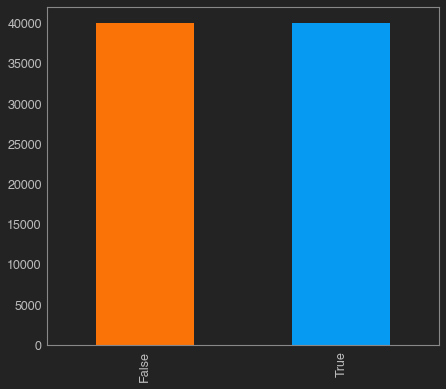

In [27]:
# create target label
df_cleaned['target'] = pos_class_mask

# add positive and negative classes together
df_concat = pd.concat([df_cleaned[neg_class].sample(updated_class_size), df_cleaned[pos_class_mask]], axis=0)
print(df_concat.groupby('target').describe()['score'])

# plot target distribution to validate
df_concat['target'].value_counts().plot(kind='bar', color=['xkcd:orange', 'xkcd:azure'])
plt.grid(False)
save_fig('class distribution after cleaning')

### Split into train / test data

In [28]:
# get training size from parameters
training_size = int(len(df_concat)*TRAIN_SIZE)

# shuffle 
df_concat_shuffled = df_concat.sample(len(df_concat))

# fill na values with a blank
df_concat_shuffled['selftext'] = df_concat_shuffled['selftext'].fillna(value='')

# generate train and test sets
train = df_concat_shuffled[:training_size]
test = df_concat_shuffled[training_size:]
print(train.shape, test.shape)
pd.to_pickle(train, "./data/train.pkl")
pd.to_pickle(test, "./data/test.pkl")

(76100, 15) (4006, 15)


## Explore the Data

In [29]:
# some useful boolean masks
is_funny = train['target'] == True

In [30]:
# examples of funny jokes
train[train['score'] >= train['score'].mean()][['title', 'selftext', 'score']].sample(10)

,title,selftext,score
328307,A Spaniard is walking through a grocery store,He spies a carton on the shelf labeled Soy Milk He smiles to himself and says softly yes you are,666
743184,Why are redneck murder cases the hardest to solve,Because all the DNA matches and there are no dental records,1849
153290,I decided to switch to a knife to preserve my ammo,The guys at Laser Tag started freaking out though,1118
611986,I like my men just how I like my women,That's it I'm bisexual,940
383122,My poor knowledge of Greek mythology has always been my,Achilles elbow,1215
888595,What do skinny jeans and cheap hotels have in common,No ball room,721
355861,My friend Dave drowned,At his funeral we got him a wreath in the shape of a lifebuoy It’s what he would’ve wanted,25584
562248,My girlfriend looked at me with her sexy eyes and said I want you to make me scream with your two fingers baby,so I poked her in the eyes,21020
471210,I am so high and I made up a joke and I want to tell it and make someone laugh but no one is home so Whats an epileptics favorite food,SEIZURE SALAD I peed,1550
401355,Shouldn't Iron man be a woman,After all he is a Fe Male,5480


In [31]:
# examples of not funny jokes
train[train['score'] == 0][['title', 'selftext']].sample(10)

,title,selftext
699962,Beyonce is having twins,I wonder if they will be Red ivy and Green ivy
514937,EA should make a special controller that let's you swipe your credit card whenever you need to reload,That way they could even make a little game out of it
733926,Why did donald trump win the election,people were in a hurry Russian to place their vote
845271,Do people ever come up and sing your own songs to you,Dave Grohl Literally all the time Me What if I say I'm not like the others
844709,why did the blonde make her boyfriend jizz in her water every morning,her doctor told her cumin in ger water would help her lose weight
56556,Is this sub dead or something,There’s been no posts this whole decade
291793,What are the two people needed to make a table,A columnist and a rower
749797,TIL that if your phone gets dropped in some water and you put it in a bowl with some rice,The rice will attract the asian to come and fix it for you
859455,What does a person feel after he lost all of his money in bad investments,The Bern
180025,What’s the deal with black people,I mean they’re not really black and they’re not really people


Saving figure density plot of log title length


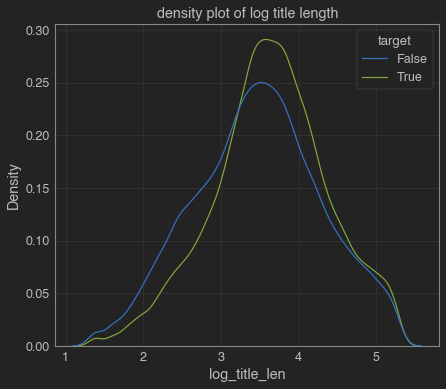

Saving figure density plot of log selftext length


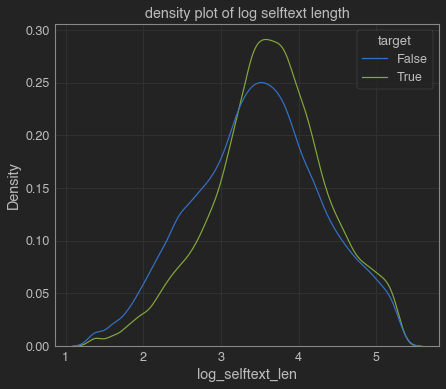

In [32]:
# plots of length
train['log_title_len'] = np.log(train['title_len'])
train['log_selftext_len'] = np.log(train['selftext_len'])

funny_df = train[train['target'] == True]
not_funny_df = train[train['target'] == False]

# plots lengths
sns.kdeplot(x='log_title_len', data=train, hue='target')
plt.title('density plot of log title length')
save_fig('density plot of log title length')
plt.show()
train['log_selftext_len'] = np.log(train['selftext_len'])
sns.kdeplot(x='log_selftext_len', data=train, hue='target')
plt.title('density plot of log selftext length')
save_fig('density plot of log selftext length')
plt.show()


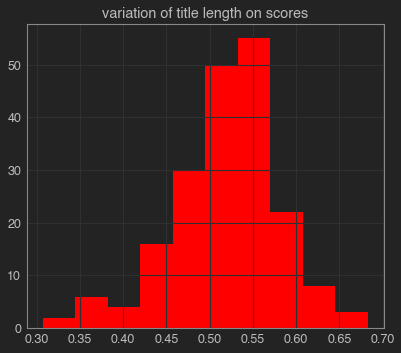

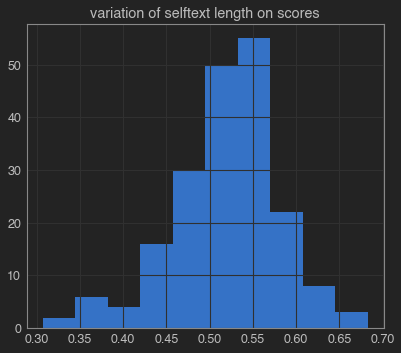

In [33]:
train.groupby(['title_len']).mean()['target'].hist(color='red')
plt.title('variation of title length on scores')
plt.show()
train.groupby(['selftext_len']).mean()['target'].hist()
plt.title('variation of selftext length on scores')
plt.show()

### Examine Time Series Data

In [34]:
# making unix created_times into readable timestamps
train['created_at'] = train['created_utc'].apply(lambda x: make_timestamp(x))
#train[['created_at', 'title', 'selftext', 'target']].head()

# create dataframes with with timestamp as index for examination
df_funny = train[is_funny].set_index('created_at', drop=True).sort_index()
df_not_funny = train[~is_funny].set_index('created_at', drop=True).sort_index()

Saving figure submissions over time


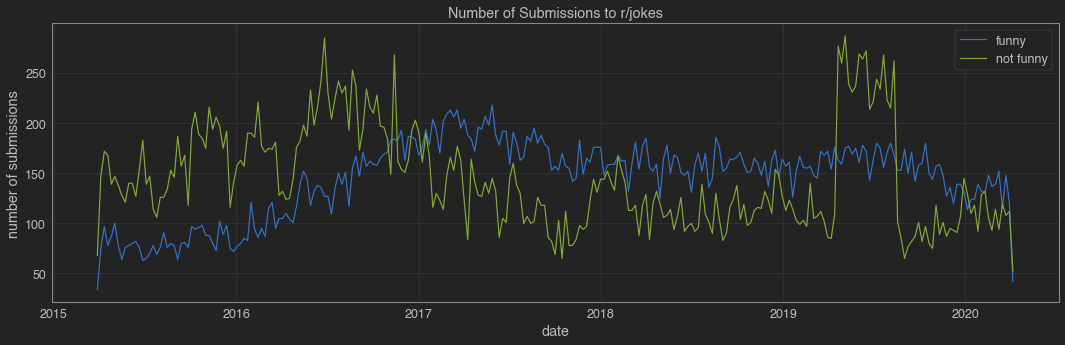

In [35]:
# plot submissions over time
plt.figure(figsize=(15, 5))

sns.lineplot(x=df_funny.resample('W').count().index, y='type', data=df_funny.resample('W').count(), label='funny')
sns.lineplot(x=df_not_funny.resample('W').count().index, y='type', data=df_not_funny.resample('W').count(), label='not funny')
plt.title('Number of Submissions to r/jokes')
plt.xlabel('date')
plt.ylabel('number of submissions')
plt.legend()
save_fig('submissions over time')
plt.show()

Saving figure average submission per hour


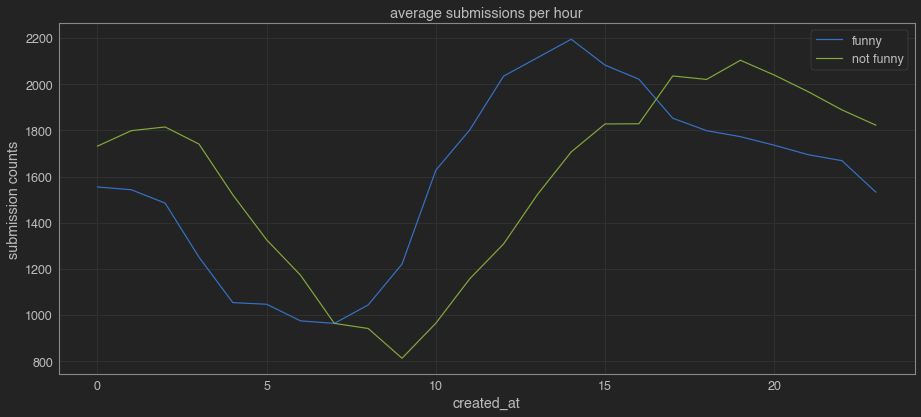

In [36]:
# average periods
plt.figure(figsize=(13, 6))
sns.lineplot(data = df_funny.groupby(df_funny.index.hour)['target'].count(), label='funny')
sns.lineplot(data = df_not_funny.groupby(df_not_funny.index.hour)['target'].count(), label='not funny', )
plt.title('average submissions per hour')
plt.ylabel('submission counts')
save_fig('average submission per hour')
plt.show()

<AxesSubplot:xlabel='created_at', ylabel='type'>

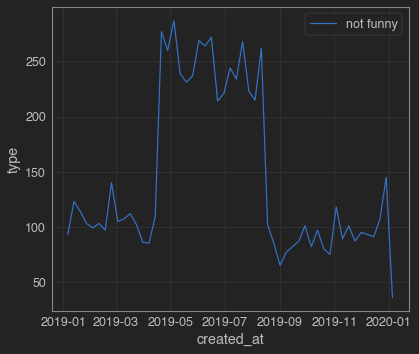

In [37]:
# taking another look at that odd event in 2019
sns.lineplot(x=df_not_funny.loc['2019'].resample('W').count().index, y='type', data=df_not_funny.loc['2019'].resample('W').count(), label='not funny')

In [38]:
not_funny_2019_counts = df_not_funny.loc['2019'].resample('W').count()
start_date = not_funny_2019_counts['2019-04':'2019-05'][not_funny_2019_counts['id']['2019-04':'2019-05'] == not_funny_2019_counts['id']['2019-04':'2019-05'].min()].index[0]
end_date = not_funny_2019_counts[start_date:"2019-12-01"][not_funny_2019_counts[start_date:"2019-12-01"]['id'] == not_funny_2019_counts[start_date:"2019-12-01"]['id'].min()].index[0]
start_date_not_funny_event, end_date_not_funny_event = str(start_date.date()), str(end_date.date())
print(f'dates of anomaly: {start_date_not_funny_event} - {end_date_not_funny_event}')

dates of anomaly: 2019-04-07 - 2019-09-01
